In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

import pandas as pd
import os
import PIL.Image as Image
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_ten_images(X_corr, X):
    n=10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display original + noise
        ax = plt.subplot(2, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(X_corr[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(X[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

def corrupt(X, eps, p_corr):
    X_all_corr = X + eps * np.random.randn(X.shape[0], X.shape[1])
    X_all_corr = np.clip(X_all_corr, 0, 1)
    mask = np.random.choice([0, 1], size=X.shape, p=[1-p_corr, p_corr]) != 0
    X_corr = X.copy()
    X_corr[mask] = X_all_corr[mask]
    return X_corr

def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar


def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    Source : http://deeplearning.net/tutorial/utilities.html#how-to-plot
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.
    """

    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape = [0,0]
    # out_shape[0] = (img_shape[0] + tile_spacing[0]) * tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1] + tile_spacing[1]) * tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4), dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                out_array[:, :, i] = np.zeros(out_shape,
                      dtype='uint8' if output_pixel_vals else out_array.dtype
                      ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(X[i], img_shape, tile_shape,
                                                        tile_spacing, scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)


        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                    else:
                        this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                        # add the slice to the corresponding position in the
                        # output array
                    out_array[
                      tile_row * (H+Hs): tile_row * (H + Hs) + H,
                      tile_col * (W+Ws): tile_col * (W + Ws) + W
                      ] \
                      = this_img * (255 if output_pixel_vals else 1)
        return out_array

In [3]:
def prox_l1(lam, x):
    return (x > lam) * (x - lam) + (x < -lam) * (x + lam)

def prox_l21(lam, x):
    e = np.linalg.norm(x, axis=0, keepdims=False)
    for i in range(len(e)):
        if e[i] > lam:
            x[:,i] = x[:,i] - lam*e[i]
        else:
            x[:,i] = np.zeros(len(x[:,i]))
    return x
    

def get_Dense_encoder(input_size, dense_units):
    encoder = tf.keras.Sequential([
        layers.Input(shape=(input_size)),
        layers.Dense(units=dense_units[0], activation='relu'),
        layers.Dense(units=dense_units[1], activation='relu'),    
    ], name='Encoder')
    return encoder

def get_Dense_decoder(input_size, dense_units):
    decoder = tf.keras.Sequential([
        layers.Input(shape=(dense_units[1])),
        layers.Dense(units=dense_units[0], activation='relu'),
        layers.Dense(units=input_size, activation='sigmoid'),
    ], name='Decoder')
    return decoder

def get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout):
    encoder = tf.keras.Sequential([
        layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True, input_shape=(timesteps, features)),
        layers.LSTM(units=LSTM_units[1], dropout=LSTM_dropout, return_sequences=False),
    ], name='Encoder')
    return encoder

def get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout):
    decoder = tf.keras.Sequential([
        layers.RepeatVector(timesteps),
        layers.LSTM(units=LSTM_units[1], dropout=LSTM_dropout, return_sequences=True),
        layers.LSTM(units=LSTM_units[0], dropout=LSTM_dropout, return_sequences=True),
        layers.TimeDistributed(layer=layers.Dense(units=features)),
    ], name='Decoder')
    return decoder

In [4]:
### Deep Dense Autoencoder Model
class DAE_Dense(Model):
    def __init__(self, input_size, dense_units):
        super(DAE_Dense, self).__init__()
        self.encoder = get_Dense_encoder(input_size, dense_units)
        self.decoder = get_Dense_decoder(input_size, dense_units)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


### Deep LSTM Autoencoder Model
class DAE_LSTM(Model):
    def __init__(self, timesteps, features, LSTM_units, LSTM_dropout):
        super(DAE_LSTM, self).__init__()
        self.encoder = get_LSTM_encoder(timesteps, features, LSTM_units, LSTM_dropout)
        self.decoder = get_LSTM_decoder(timesteps, features, LSTM_units, LSTM_dropout)
        
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

    def encode(self, x, training=False):
        encoded = self.encoder(x, training=training)
        return encoded
    
    def decode(self, x, training=False):
        decoded = self.decoder(x, training=training)
        return decoded
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Reconstruct input
            x_encoded = self.encode(x, training=True)
            x_recon = self.decode(x_encoded, training=True)
            # Calculate loss
            loss = self.compiled_loss(x, x_recon)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_recon)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [5]:
### Robust Autoencoder Model
class RobustAutoencoder:
    def __init__(self, AE_type: str, prox_type: str, input_size=784, dense_units=[200, 10], lr=3e-4, timesteps=24, features=1, LSTM_units=[64, 32], LSTM_dropout=0.0):
        super(RobustAutoencoder, self).__init__()
        assert AE_type=='Dense' or AE_type=='LSTM', 'AE_type has to be either Dense or LSTM'
        self.AE_type = AE_type
        
        assert prox_type=='l1' or prox_type=='l21', 'prox_type has to be either l1 or l21'
        self.prox_type = prox_type
        
        if self.AE_type=='Dense':
            self.AE = DAE_Dense(input_size, dense_units)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            #self.AE.build(input_shape=(input_size))
            #self.AE.summary()
            
        elif self.AE_type=='LSTM':
            self.AE = DAE_LSTM(timesteps, features, LSTM_units, LSTM_dropout)
            self.AE.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mse']
            )
            #self.AE.build(input_shape=(timesteps, features))
            #self.AE.summary()
        
        if self.prox_type=='l1':
            self.prox_fn = prox_l1
        elif self.prox_type=='l21':
            self.prox_fn = prox_l21
            
    def train_and_fit(self, X, train_iter: int, AE_train_iter: int, batch_size: int, eps: float, lam: float):
        self.L = np.zeros(X.shape)
        self.S = np.zeros(X.shape)
        self.LD = np.zeros(X.shape)
        self.LS = X
        for i in range(train_iter):
            print(f'RAE training iteration: {i+1}')
            self.LD = X - self.S
            # Now fit the autoencoder for some iters
            self.AE.fit(x=self.LD, batch_size=batch_size, epochs=AE_train_iter)
            self.LD = self.AE(self.LD).numpy()
            self.S = X - self.LD
            if self.AE_type=='LSTM':
                self.S = self.S.reshape((self.S.shape[0], self.S.shape[1]))
            self.S = self.prox_fn(lam=lam, x=self.S.T).T
            if self.AE_type=='LSTM':
                self.S = self.S.reshape((self.S.shape[0], self.S.shape[1], 1))
            c1 = tf.linalg.norm(X - self.LD - self.S) / tf.linalg.norm(X)
            c2 = tf.linalg.norm(self.LS - self.LD - self.S) / tf.linalg.norm(X)
            if c1 < eps or c2 < eps:
                print(f'Early Convergence at iter {i+1}')
                break
            self.LS = self.LD + self.S
        return self.LD, self.S
    
    def get_reconstruction(self, X):
        return self.AE(X)
    
    def transform(self, X):
        L = X - self.S
        return self.AE.encode(L)

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))
    
x_train_corr = corrupt(x_train, eps=1., p_corr=0.25)

print(f'Train data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')


digit = 4
x_train_digit = x_train[y_train==digit]
np.random.shuffle(x_train_digit)
x_train_others = x_train[y_train!=digit]
np.random.shuffle(x_train_others)

anomaly_perc = 0.05

anomalies = np.random.choice(x_train_digit.shape[0], size=int(x_train_digit.shape[0]*anomaly_perc))
x_train_anomaly = x_train_digit.copy()
x_train_anomaly[anomalies] = x_train_others[:anomalies.shape[0]]
print(f'Total number of {digit}s in the anomaly data: {x_train_anomaly.shape[0]}, correct data: '
      f'{x_train_anomaly.shape[0]-anomalies.shape[0]}, anomalies: {anomalies.shape[0]}')



Train data shape: (60000, 784)
Test data shape: (10000, 784)
Total number of 4s in the anomaly data: 5842, correct data: 5550, anomalies: 292


RAE training iteration: 1
Epoch 1/50
118/118 [==============================] - 1s 5ms/step - loss: 0.1307 - mse: 0.1307
Epoch 2/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0996 - mse: 0.0996
Epoch 3/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0916 - mse: 0.0916
Epoch 4/50
118/118 [==============================] - 0s 4ms/step - loss: 0.0870 - mse: 0.0870
Epoch 5/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0851 - mse: 0.0851
Epoch 6/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0838 - mse: 0.0838
Epoch 7/50
118/118 [==============================] - 1s 4ms/step - loss: 0.0824 - mse: 0.0824
Epoch 8/50
118/118 [==============================] - 1s 4ms/step - loss: 0.0812 - mse: 0.0812
Epoch 9/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0804 - mse: 0.0804
Epoch 10/50
118/118 [==============================] - 1s 4ms/step - loss: 0.0798 - mse: 0.0798
Epoch 11/50
118/118 [==

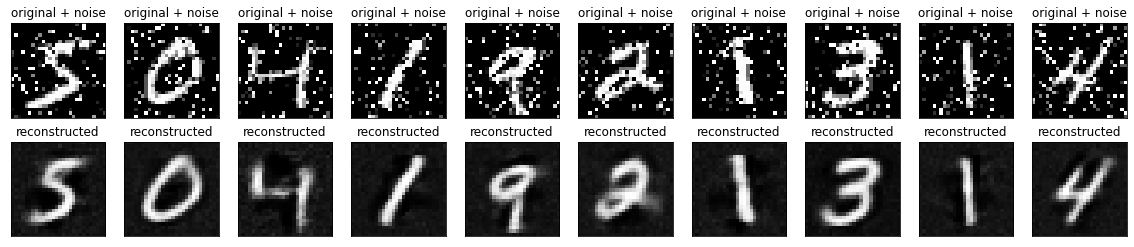

In [15]:
RAEl1Dense = RobustAutoencoder(AE_type='Dense', prox_type='l1', input_size=x_train_corr.shape[1], dense_units=[200, 10], lr=3e-4)
LD, S = RAEl1Dense.train_and_fit(X=x_train_corr, train_iter=50, AE_train_iter=50, batch_size=512, eps=1e-8, lam=1.0)
x_train_corr = x_train_corr.reshape((x_train_corr.shape[0], 28, 28, 1))
LD = LD.reshape((LD.shape[0], 28, 28, 1))
plot_ten_images(x_train_corr, LD)

In [8]:
RAEl21Dense = RobustAutoencoder(AE_type='Dense', prox_type='l21', input_size=x_train_anomaly.shape[1], dense_units=[200, 10], lr=0.005)
LD, S = RAEl21Dense.train_and_fit(X=x_train_anomaly, train_iter=5, AE_train_iter=100, batch_size=128, eps=1e-8, lam=0.05)

RAE training iteration: 1
Epoch 1/100
46/46 [==============================] - 1s 3ms/step - loss: 0.0690 - mse: 0.0690
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0415 - mse: 0.0415
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0299 - mse: 0.0299
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0264 - mse: 0.0264
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0246 - mse: 0.0246
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0234 - mse: 0.0234
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0224 - mse: 0.0224
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0217 - mse: 0.0217
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0211 - mse: 0.0211
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0206 - mse: 0.0206
Epoch 11/100
46/46 [=============

KeyboardInterrupt: 

In [58]:
inputsize = (28,28)
Image.fromarray(tile_raster_images(X=S, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21S.png")
Image.fromarray(tile_raster_images(X=RAEl21Dense.get_reconstruction(x_train_anomaly).numpy(), img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21R.png")
Image.fromarray(tile_raster_images(X=LD, img_shape=inputsize, tile_shape=(10, 10),tile_spacing=(1, 1))).save(r"l21L.png")

In [59]:
print(S)

[[-2.305239  -2.305239  -2.305239  ... -2.305239  -2.305239  -2.305239 ]
 [-2.3350143 -2.3350143 -2.3350143 ... -2.3350143 -2.3350143 -2.3350143]
 [-2.330749  -2.330749  -2.330749  ... -2.330749  -2.330749  -2.330749 ]
 ...
 [-2.3217854 -2.3217854 -2.3217854 ... -2.3217854 -2.3217854 -2.3217854]
 [-2.2959664 -2.2959664 -2.2959664 ... -2.2959664 -2.2959664 -2.2959664]
 [-2.3059874 -2.3059874 -2.3059874 ... -2.3059874 -2.3059874 -2.3059874]]


In [60]:
#detected_anomalies = (np.sum((abs(S)>0.).astype(int), axis=1)>0.).astype(int)
detected_anomalies = (np.linalg.norm(S, axis=1) > 0.).astype(int)
print(detected_anomalies)
true_anomalies = np.zeros(x_train_digit.shape[0]).astype(int)
true_anomalies[anomalies] = 1
np.sort(true_anomalies)
print(true_anomalies)
accuracy = accuracy_score(y_pred=detected_anomalies, y_true=true_anomalies)
precision = precision_score(y_pred=detected_anomalies, y_true=true_anomalies)
recall = recall_score(y_pred=detected_anomalies, y_true=true_anomalies)
f1 = f1_score(y_pred=detected_anomalies, y_true=true_anomalies)

print(f'Accuracy: {accuracy}, precision: {precision}, recall: {recall}, F1 score: {f1}')



[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
Accuracy: 0.04861348853132489, precision: 0.04861348853132489, recall: 1.0, F1 score: 0.09271955599085863


In [6]:
df = pd.read_csv(os.path.join('data', 'realKnownCause', 'machine_temperature_system_failure.csv'), delimiter=',', decimal='.')
df.drop_duplicates(subset='timestamp', keep='first', inplace=True)
ts_timestamps = df.iloc[:,0].values[33:-186]
ts_values = np.array(df.iloc[:,1].values[33:-186])
#print(ts_timestamps)
#print(ts_values)

ts_values_daily = ts_values.copy().reshape((int(ts_values.shape[0]/(12*24)), 12*24, 1))

timesteps = 12 * 24
ts_values = subsequences(ts_values, timesteps)
#ts_values = ts_values.reshape((len(ts_values), 1))
#print(ts_values)
scaler = StandardScaler()
ts_scaled = scaler.fit_transform(X=ts_values)
#print(ts_scaled)

ts_train = ts_values.reshape((ts_values.shape[0], timesteps, 1))
print(ts_train)

[[[81.90815592]
  [82.45575098]
  [83.02758267]
  ...
  [68.81053857]
  [67.95144903]
  [65.90649636]]

 [[82.45575098]
  [83.02758267]
  [83.36235646]
  ...
  [67.95144903]
  [65.90649636]
  [66.20465117]]

 [[83.02758267]
  [83.36235646]
  [81.88701566]
  ...
  [65.90649636]
  [66.20465117]
  [66.09439847]]

 ...

 [[91.44852412]
  [90.3991348 ]
  [91.07010568]
  ...
  [92.50062717]
  [91.87816911]
  [91.75578642]]

 [[90.3991348 ]
  [91.07010568]
  [91.06644841]
  ...
  [91.87816911]
  [91.75578642]
  [92.52773174]]

 [[91.07010568]
  [91.06644841]
  [92.38302496]
  ...
  [91.75578642]
  [92.52773174]
  [92.13257846]]]


In [7]:
RAEl1LSTM = RobustAutoencoder(AE_type='LSTM', prox_type='l1', timesteps=timesteps, features=1, lr=3e-4, LSTM_dropout=0.0, LSTM_units=[32, 8])
#print(RAEl1LSTM.AE.encode(ts_train[0].reshape(1, 288, 1)))
#print(RAEl1LSTM.get_reconstruction(ts_train[0].reshape(1, 288, 1)))

In [8]:
def plot_time_series(ts):
    plt.grid()
    plt.plot(np.arange(len(ts)), normal_train_data[0])
    plt.title("A Normal ECG")
    plt.show()

In [9]:
LD, S = RAEl1LSTM.train_and_fit(X=ts_train, AE_train_iter=2, train_iter=10, lam=10., batch_size=256, eps=1e-8)

RAE training iteration: 1
Epoch 1/2
87/87 [==============================] - 10s 59ms/step - loss: 7310.8711 - mse: 7310.8740
Epoch 2/2
87/87 [==============================] - 5s 58ms/step - loss: 6659.4458 - mse: 6659.4458


InternalError: Exception encountered when calling layer "lstm" (type LSTM).

Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1, 32, 1, 288, 22177, 32]  [Op:CudnnRNN]

Call arguments received by layer "lstm" (type LSTM):
  • inputs=tf.Tensor(shape=(22177, 288, 1), dtype=float32)
  • mask=None
  • training=False
  • initial_state=None

In [ ]:
print(ts_train.shape)

(22177, 288, 1)
